In [1]:
# This notebook compares the dopamine signal acquired in a modified version of the CoT task: The sound (cue) was played during the return 
# from the side port to the center port. Extracted dopamine levels are aligned to the cue and to movement (from the center to the side port). 
# Please note that this modification only applies to contralateral trials. 

In [ ]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%cd APE_paper/docs/figures_notebooks
!git checkout YvonneJohansson

In [11]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import urllib.request
from os.path import exists
import matplotlib.pylab as plt
import numpy as np
import pickle
from scipy.signal import decimate

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
import os
sys.path.insert(1, os.path.dirname(os.path.dirname(os.path.abspath(os.curdir))))
from scripts import YJ_analysis_utils as yj_utils
from scripts import yj_plotting as yj_plot

In [4]:
# Supplementary Figure 5P, 5Q & 5R:

# Get dataset information:
dataset_name = 'DataOverview_SF5PQR.csv'
zenodo = "https://zenodo.org/records/xxxxxxxxxxx/files/"
url = zenodo + dataset_name
dataset_path = '../../data/' + dataset_name

if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('DataOverview already in directory')

#print(dataset_path)
info = pd.read_csv(dataset_path)

DataOverview already in directory


In [5]:
info

,Unnamed: 0,AnimalID,Date,fiber_side,protocol1
0,1,TS24,20230929,right,SOR
1,2,TS26,20230918,right,SOR
2,3,TS27,20231003,right,SOR
3,4,TS32,20231026,right,SOR
4,5,TS33,20231102,right,SOR
5,6,TS34,20231031,right,SOR


20231003

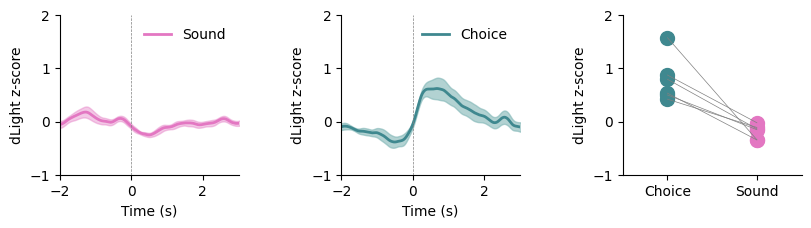

In [69]:
all_group_data = {'SOR_cue':[], 'SOR_choice':[]}
SOR_cue_peak_values = []
SOR_choice_peak_values = []
nr_mice = info.shape[0]

for i, mouse in enumerate(info['AnimalID']):
    date = str(info['Date'][i])
    fiber_side = info['fiber_side'][i]
    protocol = info['protocol1'][i]
    dataset_names = []
    CoT_trial_dataname = mouse + '_' + date + '_restructured_data.pkl'
    CoT_photo_dataname = mouse + '_' + date + '_smoothed_signal.npy' 
    dataset_names.extend([CoT_photo_dataname,CoT_trial_dataname])
    url = zenodo + dataset_name
    for j, dataset_name in enumerate(dataset_names): 
        dataset_path = '../../data/' + dataset_name
        if not exists(dataset_path):
            print('Downloading ' + dataset_name)
            urllib.request.urlretrieve(url, dataset_path)
        #else:
        #   print(dataset_name + ' already in directory')
        
        if j == 0:
            photometry_data = np.load(dataset_path)  
        if j == 1:  
            trial_data = pd.read_pickle(dataset_path)
            session_traces = yj_utils.SessionData(mouse, date, fiber_side, protocol, trial_data, photometry_data)
        
    alignements = ['SOR_choice', 'SOR_cue']
    for a, alignement in enumerate(alignements):
        if alignement == 'SOR_cue':
            curr_data = session_traces.SOR_cue
        elif alignement == 'SOR_choice':
            curr_data = session_traces.SOR_choice

        curr_data_mean = decimate(curr_data.contra_data.mean_trace, 10)
        curr_data_time = decimate(curr_data.contra_data.time_points, 10)
        curr_data_traces = decimate(curr_data.contra_data.sorted_traces, 10)
        all_group_data[alignement].append(curr_data_mean)
        
        # get the peak values:
        if alignement == 'SOR_choice':
            start_inx = 8000 # time 0 (session_traces contain raw traces of 16000 data points where the 8000th point is time 0)
            SOR_choice_time_range = curr_data_time[start_inx:start_inx + 8000]
            SOR_choice_peak_index = np.argmax(curr_data_mean[start_inx:start_inx + 8000])
            SOR_choice_peak_time = SOR_choice_time_range[SOR_choice_peak_index]
            SOR_choice_peak_value = curr_data_mean[start_inx + SOR_choice_peak_index]
            SOR_choice_peak_values.append(SOR_choice_peak_value)
        elif alignement == 'SOR_cue':
            SOR_cue_peak_value = curr_data_mean[start_inx + SOR_choice_peak_index]
            SOR_cue_peak_values.append(SOR_cue_peak_value)

        


figure = yj_plot.plot_SF5PQR(all_group_data, curr_data_time, SOR_choice_peak_values, SOR_cue_peak_values)

# uncomment here to save the plot
#dataset_path = '../../data/'
#plt.savefig(dataset_path + 'SFig5pqr.png',
#            transparent=True, bbox_inches='tight')